# Workshop 2: Connectivity principles and structure function analysis

In [5]:
mat_version = 1169

import os
import sys

HOME = os.path.expanduser("~")
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/{mat_version}"

# NOTE: adjust for your system
data_dir = f"{HOME}/SWDB_2025_Connectomics/data/"
utils_dir = f"{HOME}/SWDB_2025_Connectomics/code/utils"

sys.path.append(utils_dir)

In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
import itertools
from typing import Union, Optional
from scipy import stats

## Data prep

In [13]:
def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [11]:
dendrite_proof_root_ids = np.load(f"{data_dir}/proofread_dendrite_list_{mat_version}.npy")
axon_proof_root_ids = np.load(f"{data_dir}/proofread_axon_list_{mat_version}.npy")

In [16]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

## Connectivity principles

### #1: Connection probability vs distance

### #2: Reciprocal connections

### #3: Structure vs function

In [36]:
coreg_df = pd.read_feather(f"{data_dir}/coregistration_{mat_version}.feather")
snr_df = pd.read_feather(f"{data_dir}/snr_by_cell.feather")
corr_df = pd.read_feather(f"{data_dir}/cell_cell_correlations_by_stimulus.feather")

In [145]:
snr_coreg_df = pd.merge(snr_df, coreg_df, on=["column", "volume", "plane", "roi"])

corr_coreg_df = pd.merge(corr_df.rename(columns={"pre_roi": "roi", "pre_plane": "plane"}), coreg_df.rename(columns={"pt_root_id": "pre_pt_root_id"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "pre_roi", "plane": "pre_plane"})
corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), coreg_df.rename(columns={"pt_root_id": "post_pt_root_id"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})
corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), snr_df.rename(columns={"snr": "post_snr"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})
corr_coreg_df = pd.merge(corr_coreg_df.rename(columns={"post_roi": "roi", "post_plane": "plane"}), snr_df.rename(columns={"snr": "pre_snr"}), on=["column", "volume", "plane", "roi"]).rename(columns={"roi": "post_roi", "plane": "post_plane"})

In [146]:
snr_coreg_df

,column,volume,plane,roi,snr,pt_root_id
0,1,3,0,3,3.071593,864691132631872354
1,1,3,0,6,3.884363,864691132993747701
2,1,3,0,24,1.704388,864691132786447756
3,1,3,0,25,2.780320,864691132617961537
4,1,3,0,27,1.652257,864691132758875499
...,...,...,...,...,...,...
559,2,5,3,141,7.294687,864691132725498737
560,2,5,3,162,13.330814,864691132629014588
561,2,5,3,201,11.475102,864691132755147518
562,2,5,3,204,7.380920,864691133071474377


In [198]:
pre_ct_root_ids = np.array(cell_df[np.isin(cell_df["cell_type"], ["L3-IT"])]["pt_root_id"])
post_ct_root_ids = np.array(cell_df[np.isin(cell_df["cell_type"], ["L3-IT"])]["pt_root_id"])
# ct_root_ids = np.array(cell_df["pt_root_id"])
pre_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids, pre_ct_root_ids)]
post_root_ids = dendrite_proof_root_ids[np.isin(dendrite_proof_root_ids, post_ct_root_ids)]
analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)

In [199]:
def add_base_df(conn_df, all_pre_ids=None, all_post_ids=None):
    if all_pre_ids is None:
        all_pre_ids = np.unique(conn_df["pre_pt_root_id"])
    if all_post_ids is None:
        all_post_ids = np.unique(conn_df["post_pt_root_id"])
    all_pairs = np.array(
        list(
            itertools.product(
                all_pre_ids,
                all_post_ids,
            )
        )
    )
    all_pairs = all_pairs[all_pairs[:, 0] != all_pairs[:, 1]]
    base_df = pd.DataFrame(
        {"pre_pt_root_id": all_pairs[:, 0], "post_pt_root_id": all_pairs[:, 1]}
    )

    conn_full_df = pd.merge(
        conn_df.copy(), base_df, on=["pre_pt_root_id", "post_pt_root_id"], how="outer"
    )
    if "syn_count" in conn_full_df:
        conn_full_df["syn_count"] = conn_full_df["syn_count"].fillna(0)

    conn_full_df["connected"] = np.array(~conn_full_df["size"].isna(), dtype=bool)
    return conn_full_df

In [200]:
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

In [201]:
conn_full_df = add_base_df(conn_df, pre_root_ids, post_root_ids)

In [207]:
snr_t = 3
corr_m = np.array(corr_coreg_df["pre_snr"] > snr_t) & np.array(corr_coreg_df["post_snr"] > snr_t)
print(np.mean(corr_m))
corr_conn_full_df = pd.merge(corr_coreg_df[corr_m], conn_full_df, on=["pre_pt_root_id", "post_pt_root_id"])
corr_conn_df = pd.merge(corr_coreg_df[corr_m], conn_df, on=["pre_pt_root_id", "post_pt_root_id"])

0.681720994029369


In [208]:
stim_list = corr_conn_full_df.columns[6:13]

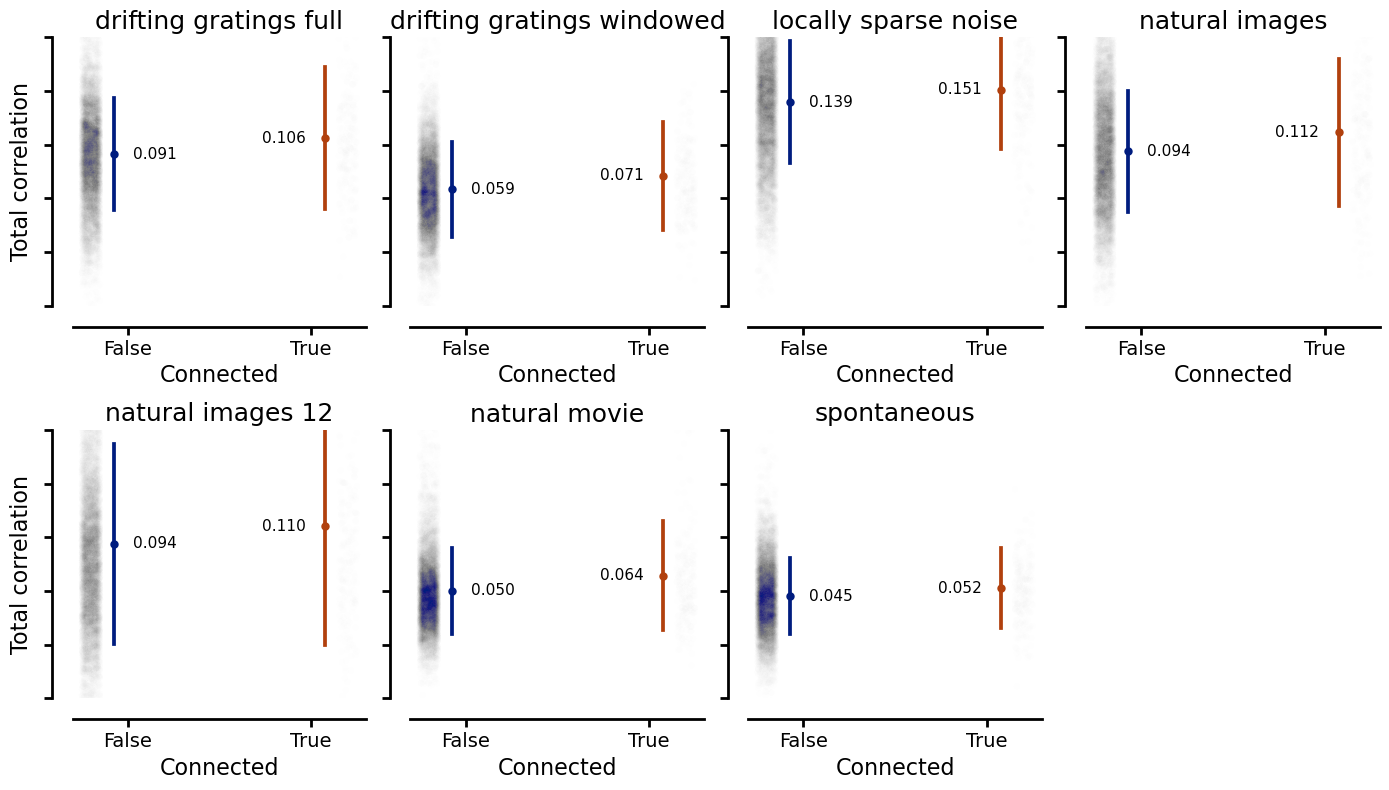

In [212]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8), sharey=True)
axes = axes.flatten()  # flatten to 1D list for easy indexing

for stim, ax in zip(stim_list, axes):
    means = corr_conn_full_df.groupby("connected")[stim].mean()
    ax.set_title(stim.replace("_", " "), fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, width=1, length=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    sns.stripplot(
        data=corr_conn_full_df, y=stim, x="connected", hue="connected",
        alpha=0.005, palette="dark", dodge=0.15, legend=False, ax=ax
    )

    sns.pointplot(
        data=corr_conn_full_df, x="connected", y=stim, hue="connected",
        dodge=0.15, palette="dark", errorbar="sd",
        markers="o", markersize=4, linestyle="none", ax=ax, legend=False
    )

    # Annotate means at custom x positions
    ax.text(0.15, means.loc[False], f"{means.loc[False]:.3f}", ha="center", va="center", fontsize=11, color="black")
    ax.text(0.85, means.loc[True], f"{means.loc[True]:.3f}", ha="center", va="center", fontsize=11, color="black")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["False", "True"], fontsize=14)

    if ax is axes[0] or ax is axes[4]:  # left-most in each row
        ax.set_ylabel("Total correlation", fontsize=16)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_xlabel("Connected", fontsize=16)
    ax.set_ylim(-.05, .2)
    ax.set_xlim(-0.3, 1.3)

# Hide any unused subplot (e.g., the 8th panel)
if len(stim_list) < len(axes):
    for ax in axes[len(stim_list):]:
        ax.axis('off')

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()
